## **Notebook para implementar la regresión con minimización del MAPE.**

Importar librerías que se usarán en el análisis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import linear_kernel
import cvxpy as cp #https://www.cvxpy.org/
from sklearn.metrics import mean_squared_error

Generación de los datos a analizar. Los datos contienen 2 predictores (x1,x2), las cuales se relacionan por medio de una función del tipo Y = 2*X1+3*X2+40. Ha esos datos se le agregan valores aleatorios para evitar que sea un ajuste perfecto.

In [2]:
np.random.seed(1)
n = 29
x1 = np.linspace(1,20,n)
x2 = np.linspace(1,20,n)
X1,X2 = np.meshgrid(x1,x2)
Y = 2*X1+3*X2+40+(5*np.random.rand(X1.shape[0],X1.shape[0])-2.5)

x1m = np.ravel(X1.T)
x2m = np.ravel(X2.T)
Xm = np.c_[x1m,x2m]
y = np.ravel(Y.T)

Visualizar los datos

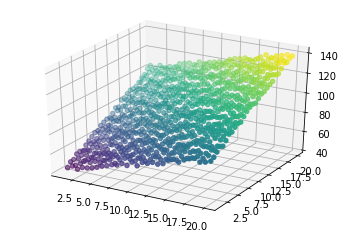

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1m, x2m, y, c=y)
plt.show()

Declaración de la funciones que se usarán

In [4]:
# Funcion MAPE
def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
# Optimization classic E-regression with cvxpy
def SVR_E(X,y,epsilon=0.01,c=10):
    # epsilon = 0.01 # margin max
    # c = 10 # alphas constraint
    umbral = 1E-5 # umbral to define a vector support
    
    nsamples,nfeatures = np.shape(X)
    onev = np.ones((nsamples,1))
    
    # Kernel matrix
    K = linear_kernel(X,X)

    alpha1 = cp.Variable((nsamples,1))
    alpha2 = cp.Variable((nsamples,1))
    
    #% Objective function construction:classic E-regression
    Ev = onev*epsilon
    objective = cp.Minimize((1/2)*cp.quad_form(alpha1-alpha2, K) + Ev.T @ (alpha1+alpha2) - y.T @ (alpha1 - alpha2))
    
    # Constrains in matrix form
    G = np.float64(np.concatenate((np.identity(nsamples),-np.identity(nsamples))))
    h = np.float64(np.concatenate((c*np.ones((nsamples,1)),np.zeros((nsamples,1)))))
    
    constraints = [onev.T @ (alpha1-alpha2) == 0, G @ alpha1 <= h, G @ alpha2 <= h]
    
    # The optimal objective value is returned by `prob.solve()`.
    prob = cp.Problem(objective,constraints)
    result = prob.solve()
    
    alpha1 = np.array(alpha1.value)
    alpha2 = np.array(alpha2.value)
    alphas = alpha1-alpha2
    indx = abs(alphas) > umbral
    alpha_sv = alphas[indx]
    x_sv = X[indx[:,0],:]
    y_sv = y[indx[:,0]]
    
    
    w = np.sum(np.transpose(np.tile(alpha_sv,(nfeatures,1)))*x_sv,axis=0)
    b = np.mean(y_sv-np.dot(x_sv,w))
    
    print('w=')
    print(w)
    print('b=')
    print(b)
    
    return w,b

In [6]:
# Optimization E-regression MAPE with cvxpy
def SVR_E_MAPE(X,y,epsilon=0.01,c=10):
    # epsilon = 0.01 # margin max
    # c = 10 # alphas constraint
    umbral = 1E-5 # umbral to define a vector support
    
    nsamples,nfeatures = np.shape(X)
    onev = np.ones((nsamples,1))
    
    # Kernel matrix
    K = linear_kernel(X,X)
    
    alpha1 = cp.Variable((nsamples,1))
    alpha2 = cp.Variable((nsamples,1))
    
    #% Objective function construction: E-MAPE-regression
    Ev = np.reshape(y,(nsamples,1))*epsilon
    objective = cp.Minimize((1/2)*cp.quad_form(alpha1-alpha2, K) + Ev.T @ (alpha1+alpha2) - y.T @ (alpha1 - alpha2))
    
    # Constrains in matrix form
    G = np.float64(np.concatenate((np.identity(nsamples),-np.identity(nsamples))))
    h=np.float64(np.concatenate((c/np.reshape(y,(nsamples,1)),np.zeros((nsamples,1)))))
    constraints = [onev.T @ (alpha1-alpha2) == 0, G @ alpha1 <= h, G @ alpha2 <= h]
    
    # The optimal objective value is returned by `prob.solve()`.
    prob = cp.Problem(objective,constraints)
    result = prob.solve()
    
    
    alpha1 = np.array(alpha1.value)
    alpha2 = np.array(alpha2.value)
    alphas = alpha1-alpha2
    indx = abs(alphas) > umbral
    alpha_sv = alphas[indx]
    x_sv = X[indx[:,0],:]
    y_sv = y[indx[:,0]]
    
    
    w = np.sum(np.transpose(np.tile(alpha_sv,(nfeatures,1)))*x_sv,axis=0)
    b = np.mean(y_sv-np.dot(x_sv,w))
    
    print('w=')
    print(w)
    print('b=')
    print(b)
    
    return w,b


In [7]:
#%% Optimization classic v formulation E-regression with cvxpy
def SVR_vE(X,y,epsilon=0.01,c=10,v=1):
#    epsilon = 0.01 # margin max
#    v = 1 # New term
#    c = 10 # alphas constraint
    
    umbral = 1E-5 # vector support 
    nsamples,nfeatures = np.shape(X)
    onev = np.ones((nsamples,1))
    
    # Kernel matrix
    K = linear_kernel(X,X)
    
    alpha1 = cp.Variable((nsamples,1))
    alpha2 = cp.Variable((nsamples,1))
    
    #% Objective function construction: classic vE-regression
    objective = cp.Minimize((1/2)*cp.quad_form(alpha1-alpha2, K) - y.T @ (alpha1 - alpha2))
    
    # Constrains in matrix form
    G = np.float64(np.concatenate((np.identity(nsamples),-np.identity(nsamples))))
    h = np.float64(np.concatenate((c*np.ones((nsamples,1)),np.zeros((nsamples,1)))))
    
    constraints = [onev.T @ (alpha1-alpha2) == 0,
                   onev.T @ (alpha1+alpha2) == c*v,
                   G @ alpha1 <= h,
                   G @ alpha2 <= h]
    
    # The optimal objective value is returned by `prob.solve()`.
    prob = cp.Problem(objective,constraints)
    result = prob.solve()
    
    alpha1 = np.array(alpha1.value)
    alpha2 = np.array(alpha2.value)
    alphas = alpha1-alpha2
    indx = abs(alphas) > umbral
    alpha_sv = alphas[indx]
    x_sv = X[indx[:,0],:]
    y_sv = y[indx[:,0]]
    
    
    w = np.sum(np.transpose(np.tile(alpha_sv,(nfeatures,1)))*x_sv,axis=0)
    b = np.mean(y_sv-np.dot(x_sv,w))
    
    print('w=')
    print(w)
    print('b=')
    print(b)
    
    return w,b

In [8]:
#%% Optimization v formulation MAPE-regression usando cvxpy
def SVR_vMAPE(X,y,epsilon=0.01,c=10,v=1):
#    epsilon = 0.01 # margin max
#    v = 1 # New term
#    c = 10 # alphas constraint
    
    umbral = 1E-5 # vector support 
    nsamples,nfeatures = np.shape(X)
    onev = np.ones((nsamples,1))
    
    # Kernel matrix
    K = linear_kernel(X,X)
    
    alpha1 = cp.Variable((nsamples,1))
    alpha2 = cp.Variable((nsamples,1))
    
    #% Objective function construction: vE-MAPE-regression
    objective = cp.Minimize((1/2)*cp.quad_form(alpha1-alpha2, K) - y.T @ (alpha1 - alpha2))
    
    # Constrains in matrix form
    G = np.float64(np.concatenate((np.identity(nsamples),-np.identity(nsamples))))
    # h=np.float64(np.concatenate((c/np.reshape(y,(nsamples,1)),np.zeros((nsamples,1)))))
    
    ##### Esto se modificó el 01-06-2020 #######
    h=np.float64(np.concatenate((100*c/np.reshape(y,(nsamples,1)),np.zeros((nsamples,1)))))
    
    constraints = [onev.T @ (alpha1-alpha2) == 0,
                   (y/100).T @ (alpha1+alpha2) == c*v,
                   G @ alpha1 <= h,
                   G @ alpha2 <= h]
    ##############################
    
    # The optimal objective value is returned by `prob.solve()`.
    prob = cp.Problem(objective,constraints)
    result = prob.solve()
    
    alpha1 = np.array(alpha1.value)
    alpha2 = np.array(alpha2.value)
    alphas = alpha1-alpha2
    indx = abs(alphas) > umbral
    alpha_sv = alphas[indx]
    x_sv = X[indx[:,0],:]
    y_sv = y[indx[:,0]]
    
    
    w = np.sum(np.transpose(np.tile(alpha_sv,(nfeatures,1)))*x_sv,axis=0)
    b = np.mean(y_sv-np.dot(x_sv,w))
    
    print('w=')
    print(w)
    print('b=')
    print(b)
    
    return w,b

Aplicación de la regresión usando la aproximación Epsilon

w=
[2.00773234 2.98481965]
b=
40.096074035250105


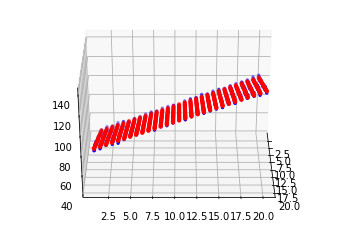

In [9]:
# Aplicar la regresion epsilon
w_Ereg,b_Ereg = SVR_E(Xm,y,epsilon=0.01,c=10)

#% Simular el modelo
y_Ereg = np.dot(Xm,w_Ereg)+b_Ereg

#% Visualizar los resultados
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1m, x2m, y, c='b',s=5)
ax.scatter(x1m, x2m, y_Ereg, c='r',s=10)
ax.view_init(30, 0)
plt.show()

Aplicación de la regresión usando la aproximación Epsilon con MAPE

w=
[1.99961981 3.00093896]
b=
40.01836496697336


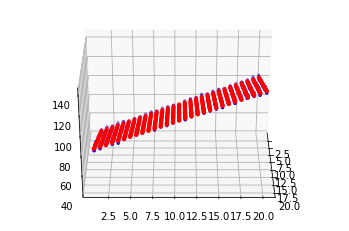

In [10]:
# Aplicar la regresion epsilon MAPE
w_mape,b_mape = SVR_E_MAPE(Xm,y,epsilon=0.01,c=10)

#% Simular el modelo
y_mape = np.dot(Xm,w_mape)+b_mape

#% Visualizar los resultados
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1m, x2m, y, c='b',s=5)
ax.scatter(x1m, x2m, y_mape, c='r',s=10)
ax.view_init(30, 0)
plt.show()

Aplicación de la regresión usando la aproximación clásica vEpsilon

w=
[2.00265851 2.99894073]
b=
41.20403509292471


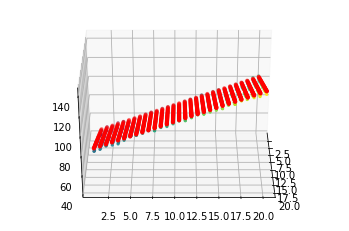

In [11]:
#%% Aplicar la regresion epsilon con formulacion v
w_vE,b_vE = SVR_vE(Xm,y,epsilon=0.01,c=10,v=1)

#% Simular el modelo
y_vE = np.dot(Xm,w_vE)+b_vE

#% Visualizar los resultados
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1m, x2m, y, c=y,s=5)
ax.scatter(x1m, x2m, y_vE, c='r',s=10)
ax.view_init(30, 0)
plt.show()

Aplicación de la regresión usando la aproximación vEpsilon con MAPE

w=
[2.08424575 3.14551439]
b=
37.60483462141849


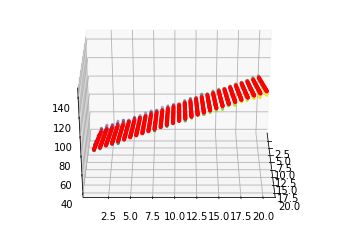

In [12]:
#%% Aplicar la regresion epsilon con formulacion v
w_vmape,b_vmape = SVR_vMAPE(Xm,y,epsilon=0.01,c=10,v=1)

#% Simular el modelo
y_vmape = np.dot(Xm,w_vmape)+b_vmape

#% Visualizar los resultados
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1m, x2m, y, c=y,s=5)
ax.scatter(x1m, x2m, y_vmape, c='r',s=10)
ax.view_init(30, 0)
plt.show()

Evaluacion de ambas implementaciones

In [15]:
rmse_ereg,mape_ereg = mean_squared_error(y,y_Ereg),mean_absolute_percentage_error(y,y_Ereg)
rmse_mape,mape_mape = mean_squared_error(y,y_mape),mean_absolute_percentage_error(y,y_mape)
rmse_vE,mape_vE = mean_squared_error(y,y_vE),mean_absolute_percentage_error(y,y_vE)
rmse_vmape,mape_vmape = mean_squared_error(y,y_vmape),mean_absolute_percentage_error(y,y_vmape)

In [16]:
print('\n\n\t\t\t RMSE\t\t MAPE\n Formulation Ereg\t %0.4f\t\t %0.4f\n Formulation Emape\t %0.4f\t\t %0.4f\n Formulation vE\t\t %0.4f\t\t %0.4f\n Formulation vmape\t %0.4f\t\t %0.4f'%(rmse_ereg,mape_ereg,rmse_mape,mape_mape,rmse_vE,mape_vE,rmse_vmape,mape_vmape))



			 RMSE		 MAPE
 Formulation Ereg	 2.0987		 1.4371
 Formulation Emape	 2.0904		 1.4387
 Formulation vE		 3.5371		 1.7698
 Formulation vmape	 2.9776		 1.6445
